# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 20.10.2020

Мягкий дедлайн: 01:59MSK 02.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 01:59MSK 05.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 10 + 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). 

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear', probability=True))
])

searcher = GridSearchCV(pipeline, {'svc__C': np.logspace(-2, 2, 30)}, scoring='roc_auc',
                        cv=10, n_jobs=-1, verbose=True)
searcher.fit(X_train, y_train)
svm_c = searcher.best_params_['svc__C']

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 32.9min finished


На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью `sklearn` можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты. 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 11
sns.set(style='darkgrid')

AUC-ROC score = 0.84792, manual AUC-ROC = 0.84792


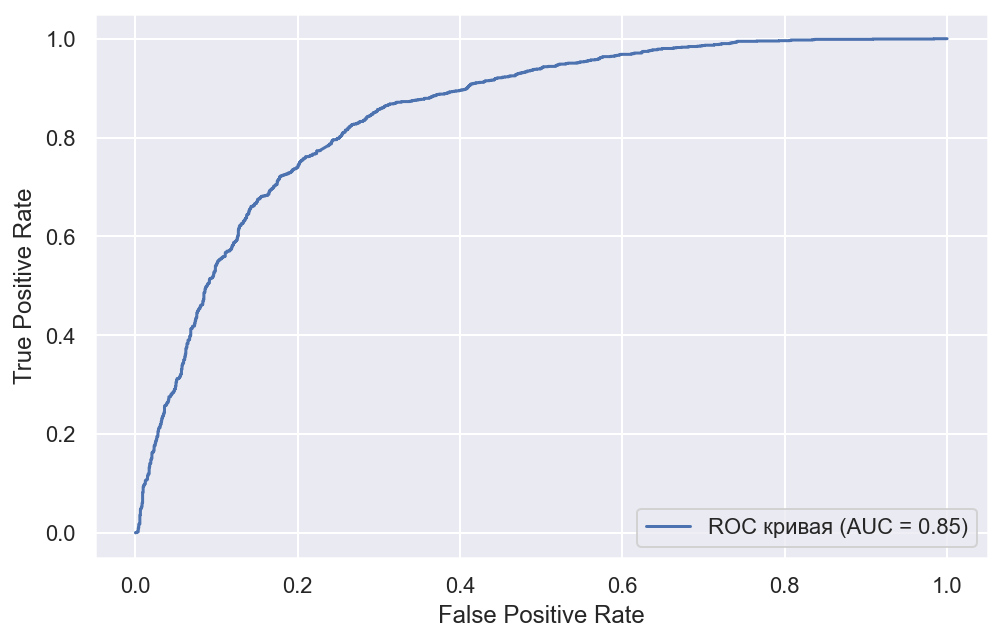

In [5]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

y_pred = searcher.best_estimator_.predict_proba(X_test)[:, 1:]

roc_auc = roc_auc_score(y_test, y_pred)
roc_auc_ = auc(*roc_curve(y_test, y_pred)[:2])  # fpr по x, tpr по y – roc auc

plot_roc_curve(searcher.best_estimator_, X_test, y_test, name='ROC кривая')
print('AUC-ROC score = ', round(roc_auc, 5), ', manual AUC-ROC = ', round(roc_auc_, 5), sep='')

AUC-PR score = 0.81534, manual AUC-PR = 0.81495


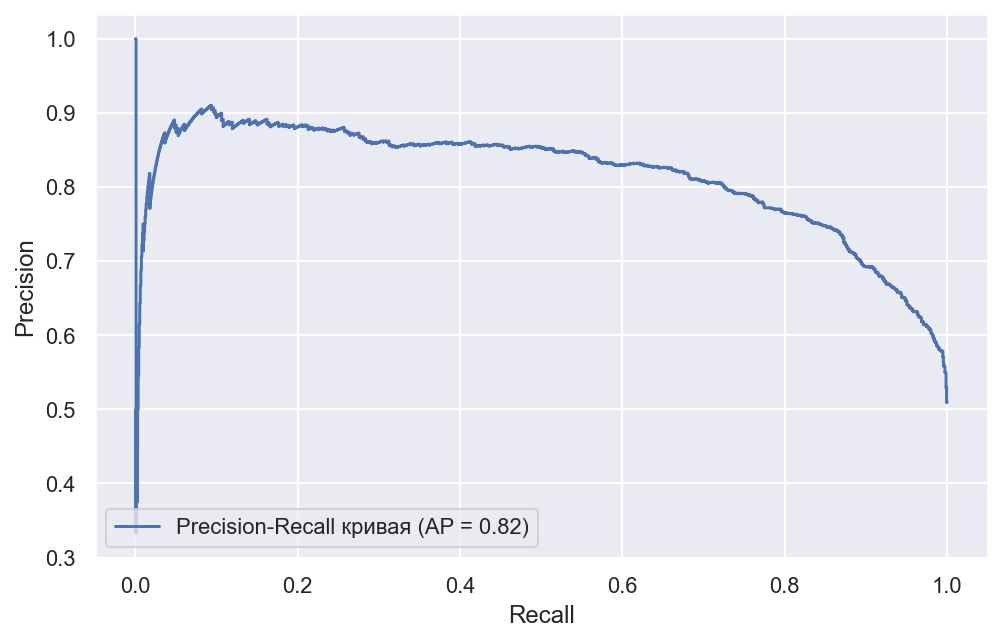

In [6]:
pr_auc = average_precision_score(y_test, y_pred)
pr_auc_ = auc(*precision_recall_curve(y_test, y_pred)[1::-1])  # precision по y, recall по x

plot_precision_recall_curve(searcher.best_estimator_, X_test, y_test, name='Precision-Recall кривая')
print('AUC-PR score = ', round(pr_auc, 5), ', manual AUC-PR = ', round(pr_auc_, 5), sep='')

<div class='alert alert-block alert-info'>
Первый способ – встроенная функция, второй – сначала построить кривую (точнее найти ее точки), а затем по точкам с помощью функции <b>auc</b> посчитать площадь под кривой. Судя по результатам, разницы особо и нет.
    
Полагаю, что в случае PR разница (если брать значение функции average precision score как правильное, то погрешность – 0.047833%) обусловлена небольшой peculiarity полученных результатов. То есть average precision score аппроксимирует площадь прямоугольником, значит не может учесть все нюансы.</div>

In [7]:
result = pd.DataFrame({'SVM': [roc_auc, roc_auc_, pr_auc, pr_auc_]},
                      index=['ROC-AUC', 'manual ROC-AUC', 'PR-AUC', 'manual PR-AUC'])

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [8]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', LogisticRegression())
])

searcher = GridSearchCV(pipeline, {'regression__C': np.logspace(-2, 2, 30)}, scoring='roc_auc',
                        cv=10, n_jobs=-1, verbose=True)
searcher.fit(X_train, y_train)
logit_c = searcher.best_params_['regression__C']

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.4s finished


AUC-ROC score = 0.84785, manual AUC-ROC = 0.84785


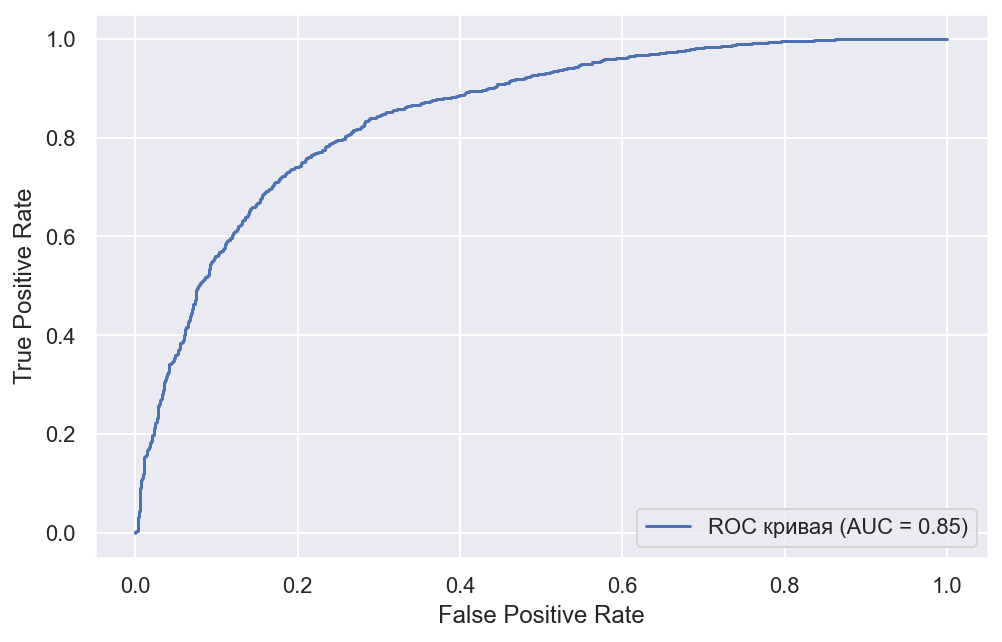

In [9]:
y_pred = searcher.best_estimator_.predict_proba(X_test)[:, 1:]

roc_auc = roc_auc_score(y_test, y_pred)
roc_auc_ = auc(*roc_curve(y_test, y_pred)[:2])  # fpr по x, tpr по y – roc auc
plot_roc_curve(searcher.best_estimator_, X_test, y_test, name='ROC кривая')
print('AUC-ROC score = ', round(roc_auc, 5), ', manual AUC-ROC = ', round(roc_auc_, 5), sep='')

AUC-PR score = 0.82948, manual AUC-PR = 0.82922


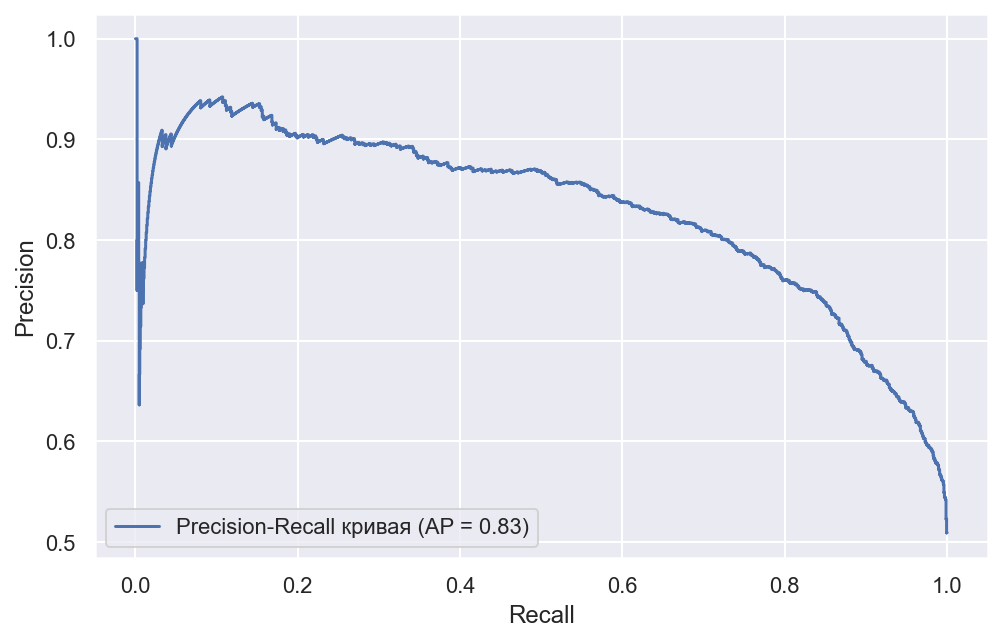

In [10]:
pr_auc = average_precision_score(y_test, y_pred)
pr_auc_ = auc(*precision_recall_curve(y_test, y_pred)[1::-1])  # precision по y, recall по x
plot_precision_recall_curve(searcher.best_estimator_, X_test, y_test, name='Precision-Recall кривая')
print('AUC-PR score = ', round(pr_auc, 5), ', manual AUC-PR = ', round(pr_auc_, 5), sep='')

In [11]:
result['Logistic Regression'] = [roc_auc, roc_auc_, pr_auc, pr_auc_]
result

,SVM,Logistic Regression
ROC-AUC,0.847921,0.847850
manual ROC-AUC,0.847921,0.847850
PR-AUC,0.815337,0.829475
manual PR-AUC,0.814948,0.829216


<div class='alert alert-block alert-info'>
<b>Про способы подсчета AUC:</b> по таблице видно, что по разному вычисленные PR-AUC логистической регрессии отличаются на четвертом знаке после запятой (SVM – на третьем), объяснить я это могу тем, что резкое падение на графике PR логистической регрессии меньше.
    
<b>Различия результатов моделей:</b> ROC кривая тем лучше, чем точнее мы определяем принадлежность объекта к классу, а SVM как раз над этим и работает. В то время как SVM двигает margin до единицы и дальше перестает что-либо улучшать (поэтому калибровочная кривая далека от диагонали (относительно LR), логистическая регрессия максимизирует отступы и оценивает вероятность лучше.</div>

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

<div class='alert alert-block alert-info'>
<b>Код ниже краденный!</b> <a href='https://towardsdatascience.com/support-vector-machines-svm-clearly-explained-a-python-tutorial-for-classification-problems-29c539f3ad8'>Ссылка на источник.</a>

Голубые точки – класс 0, оранжевые – 1</div>

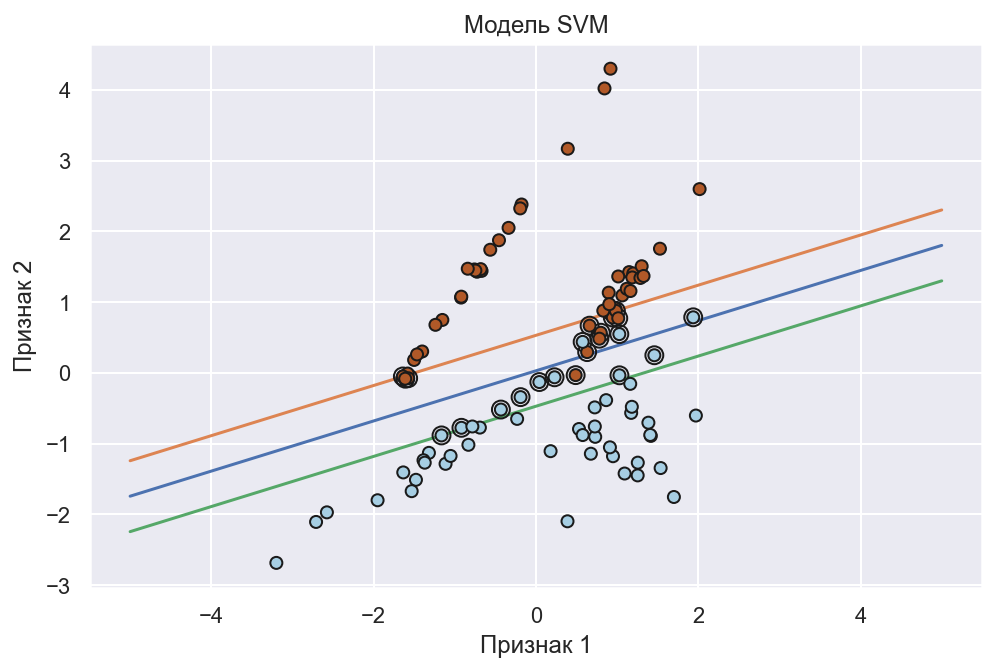

In [12]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=17)
model = SVC(C=svm_c, kernel='linear').fit(X, y)

# строим границу
# сначала выражаем y(x)
weights = model.coef_[0]
a = -weights[0] / weights[1]
x_border = np.linspace(-5, 5)
y_border = a * x_border - (model.intercept_[0]) / weights[1]
plt.plot(x_border, y_border)

# строим отсутпы
margin = 1 / np.linalg.norm(model.coef_)
y_upper = y_border + np.sqrt(1 + a**2) * margin
y_lower = y_border - np.sqrt(1 + a**2) * margin
plt.plot(x_border, y_upper)
plt.plot(x_border, y_lower)

# точки, обведенные черным, – support vectors
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
            s=80, facecolors='none', zorder=10, edgecolors='k')
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolors='k')
plt.title('Модель SVM')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2');

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость, а приближает в каждой точке пространства объектов правдоподобие положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

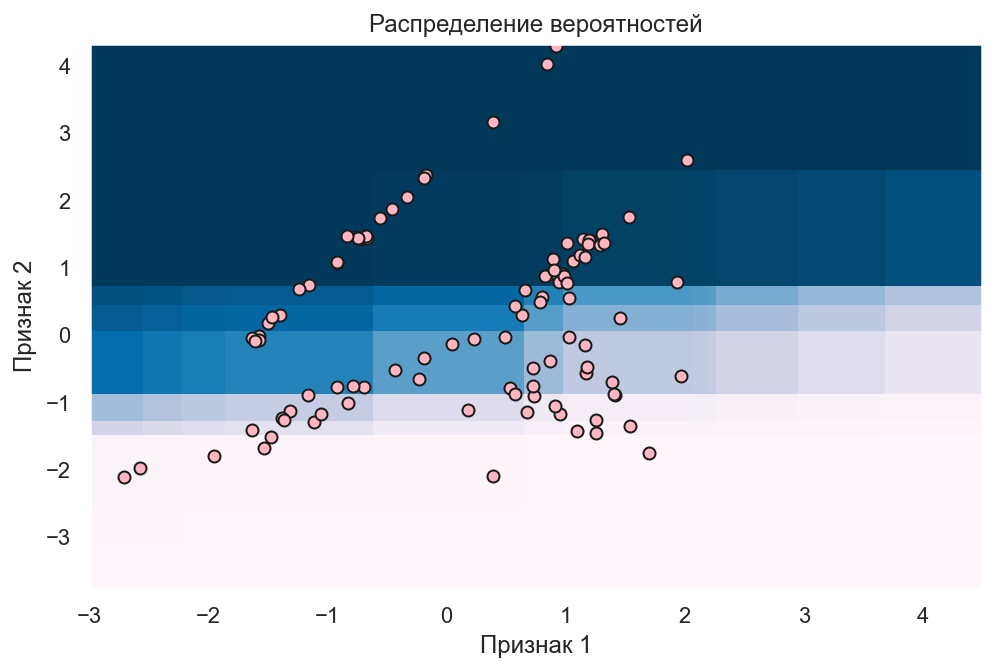

In [13]:
model = LogisticRegression(C=logit_c).fit(X, y)

# генерирую объекты, чтобы найти цвет
X_1, y_1 = make_classification(n_samples=425, n_features=2,
                               n_informative=2, n_redundant=0,
                               random_state=17)
grid = np.meshgrid(X_1[:, 0], X_1[:, 1])
color = np.vstack((np.ravel(grid[0]), np.ravel(grid[1]))).T       # нахожу цвет
color = model.predict_proba(color)[:, 1].reshape(425, -1)         # привожу к нужному размеру

plt.pcolor(grid[0], grid[1], color, cmap=plt.cm.PuBu)             # заливка цвета
plt.scatter(X[:, 0], X[:, 1], color='lightpink', edgecolors='k')  # рисую свои объекты
plt.xlim([-3, 4.5])
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Распределение вероятностей');

<div class='alert alert-block alert-info'>
Для регрессии код мой. Границу можно провести примерно такую же, как и для SVM.

Чем темнее цвет, тем выше вероятность принадлежности объекта к классу 1</div>

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [14]:
def plot_calibration_curve(y_test, preds, plot=True):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)                                     # (l - r) / 2
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))  # np.min()
    if not plot:
        return bin_middle_points, bin_real_ratios
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])

Сгенерируйте синтетический датасет аналогично использованному в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [15]:
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

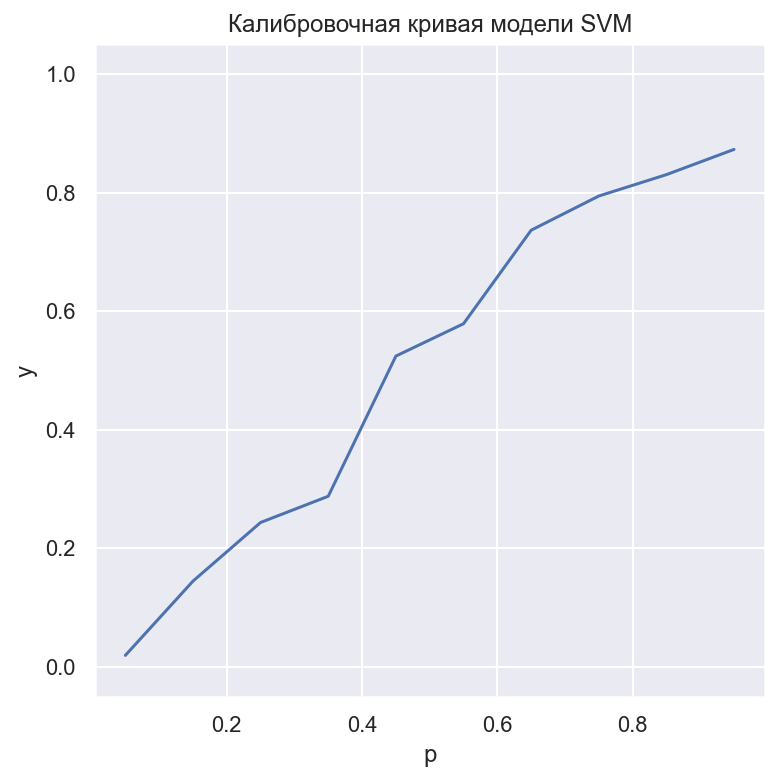

In [16]:
svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=svm_c, kernel='linear', probability=True))
])

svm.fit(X_train, y_train)
svm_pred = svm.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, svm_pred)
plt.xlabel('p')
plt.ylabel('y')
plt.title('Калибровочная кривая модели SVM');

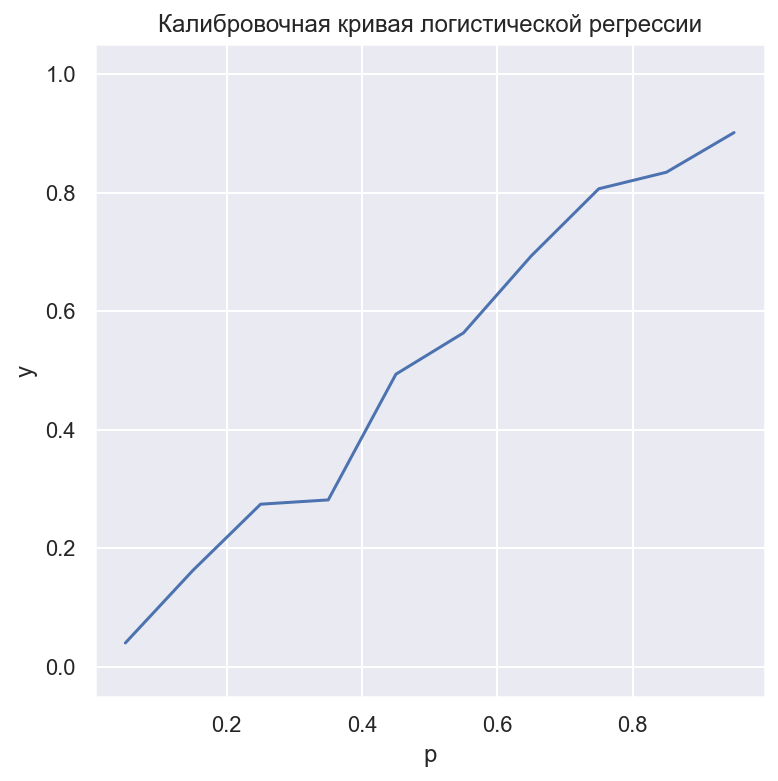

In [17]:
logit = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(C=logit_c))
])

logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, logit_pred)
plt.xlabel('p')
plt.ylabel('y')
plt.title('Калибровочная кривая логистической регрессии');

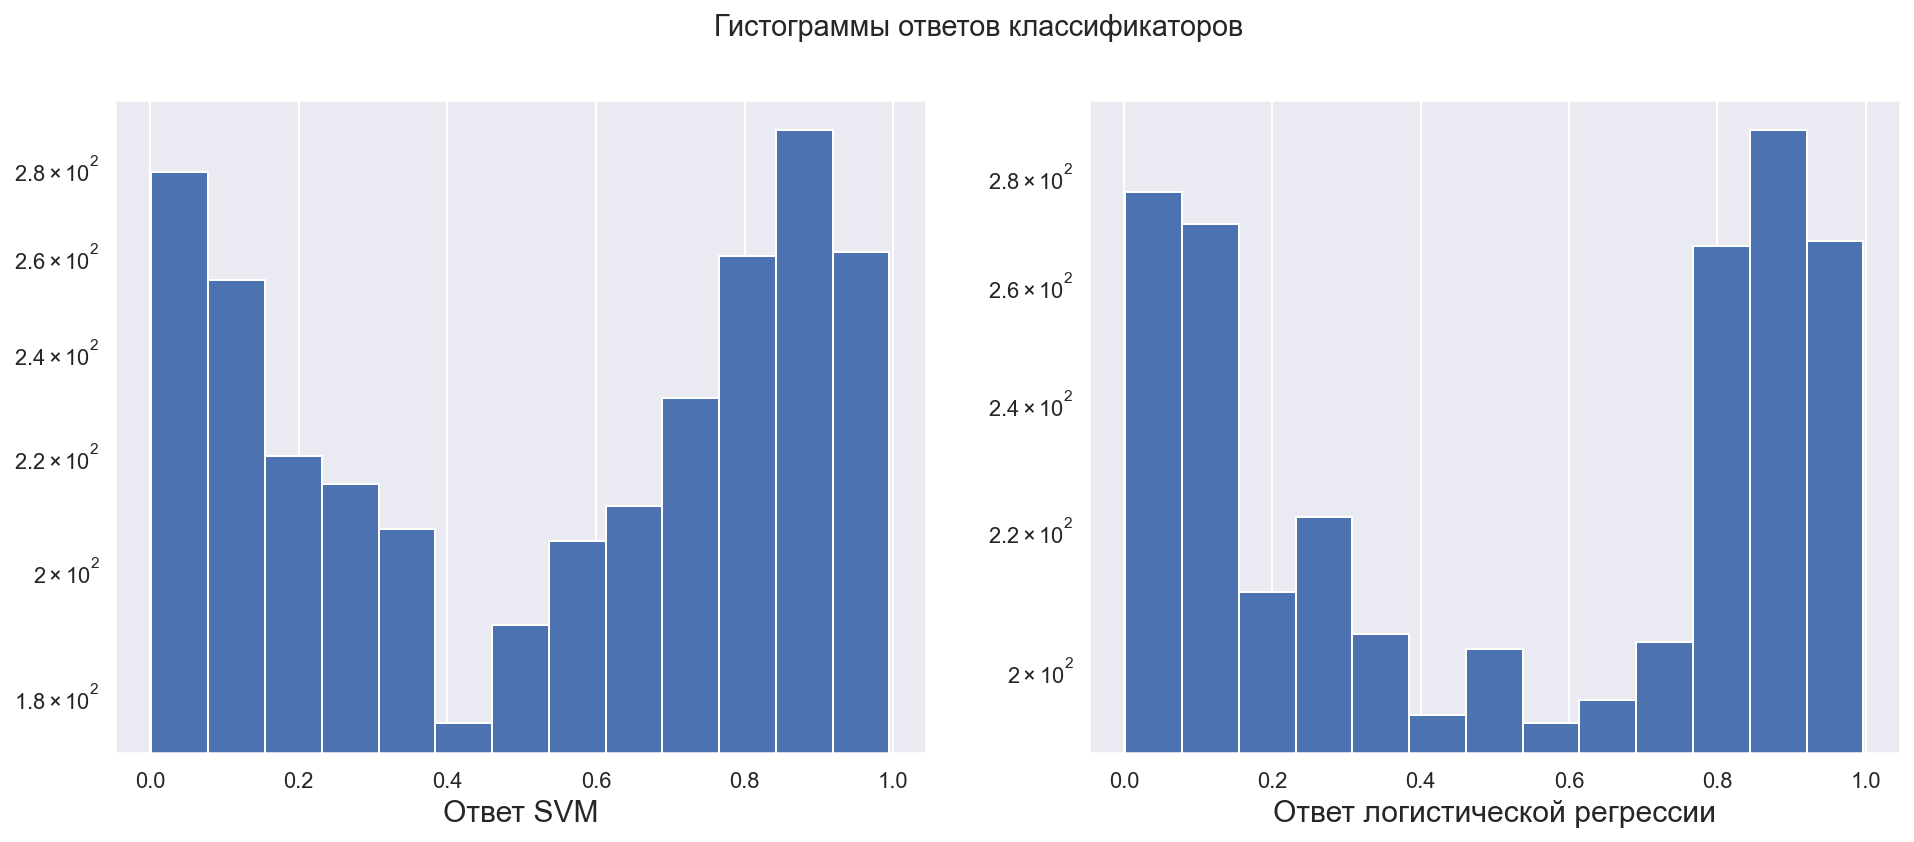

In [18]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Гистограммы ответов классификаторов')
plt1.hist(svm_pred, log=True, bins=13)
plt2.hist(logit_pred, log=True, bins=13)
plt1.set_xlabel('Ответ SVM', fontsize=15)
plt2.set_xlabel('Ответ логистической регрессии', fontsize=15);

<div class='alert alert-block alert-info'>
В логарифмическом масштабе лучше видно, как логистическая гистограмма логистической регрессии похожа на график параболы – логистическая регрессия стремится оценить вероятность и максимизировать отступ, в то время как SVM достаточно провести границу и разделить данные на два класса.

По калибровочным кривым видны эти различия: кривая SVM tends to have (пусть и незначительно) такие выпуклость и вогнутость, как, например, сигмоида.</div>

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [19]:
from sklearn.calibration import CalibratedClassifierCV

clb = CalibratedClassifierCV(svm, cv='prefit')
clb.fit(X_valid, y_valid)

clb_svm_pred = clb.predict_proba(X_test)[:, 1]

878.689163664866
[0.         0.06472287]
39.23681912496219
[-1.01        0.06475991]
40.962724229806696
[-1.01271181  0.14368815]
19.631352552746815
[-1.06220911  0.14665502]
1.1613002283409264
[-1.10795895  0.15131953]
0.035648803182860206
[-1.11084816  0.15172878]
9.967834427637712e-05
[-1.11094029  0.15174722]


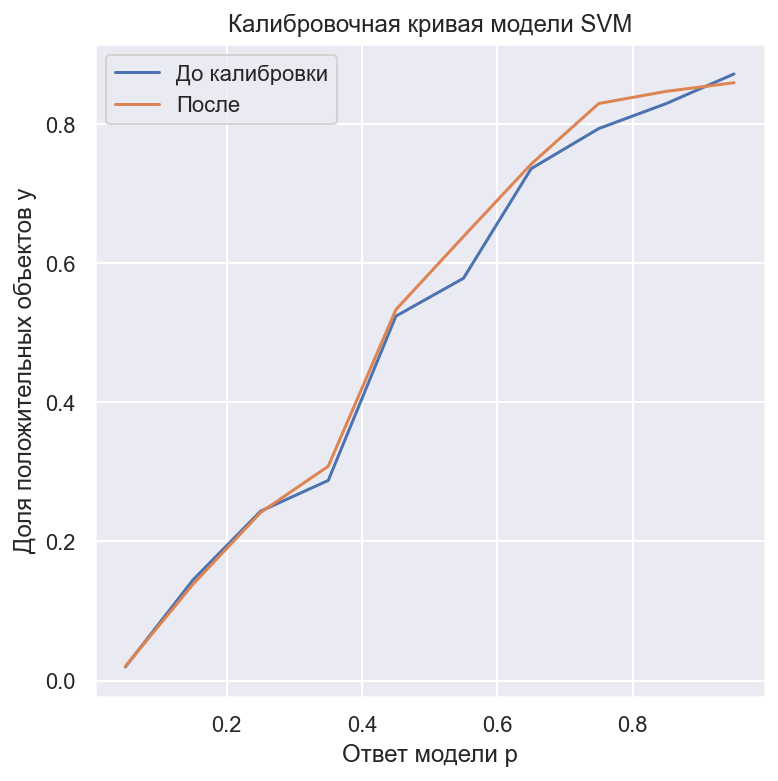

In [20]:
x1, y1 = plot_calibration_curve(y_test, svm_pred, plot=False)
x2, y2 = plot_calibration_curve(y_test, clb_svm_pred, plot=False)

plt.figure(figsize=(6,6))
plt.plot(x1, y1, label='До калибровки')
plt.plot(x2, y2, label='После')
plt.legend()
plt.xlabel('Ответ модели p')
plt.ylabel('Доля положительных объектов y')
plt.title('Калибровочная кривая модели SVM');

In [21]:
pr_auc1 = average_precision_score(y_test, svm_pred)
pr_auc2 = average_precision_score(y_test, clb_svm_pred)
print('AUC-PR score до калибровки = ', round(pr_auc1, 5), '\nAUC-PR после калибровки = ', round(pr_auc2, 5), sep='')

AUC-PR score до калибровки = 0.80819
AUC-PR после калибровки = 0.80821


<div class='alert alert-block alert-info'>
На мой взгляд, калибратор немного сгладил кривую и "размазал" вероятности. Немного.</div>

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

<div class='alert alert-block alert-info'>
    <b>We train an SVM, then train the parameters of an additional sigmoid function to map the SVM outputs to probabilities.</b>

На вход подается SVM, fitted on train dataset. <b>f</b> is the output of SVM's decision function. Then we construct a model – a parametric sigmoid function $$P(y = 1|f) = {1\over{1 + e^{Af + B}}}$$ The parameters A and B are fit using maximum likelihood estimation.
    
In order to avoid overfitting define a new training set: $t_i = {y_i + 1\over{2}}$, where t_i are target probabilities.
    
The objective function is negative log likelihood $$-\sum\limits_{i} t_i\log(p_i) + (1 - t_i)\log(1 - p_i),$$ where $$p_i = {1\over{1 + e^{Af_i + B}}}.$$
    
<i>SVM produces outputs $f_i$ that are biased estimators of $f$. At the margin SVM forces $f_i$ to have absolute value 1. The $f_i$'s beyond the margin are unbiased. However, the bias of linear SVM outputs is not severe. Therefore, for linear SVM, it is possible to fit the sigmoid on the training set.</i> – я проверила это утверждение, результат не слишком хорош. При переходе к $t_i = {y_i + 1\over{2}}$ калибровочная кривая становится похожа на правую ветвь параболы (ветви вверх). Лучший результат при $t_+ = {n_+ + 1\over{n_+ + 2}}$, $t_- = {1\over{n_- + 2}}$
</div>

In [22]:
from scipy.optimize import minimize

def loglikelihood(x, f, y):
    p = 1 / (1 + np.exp(x[0] * f + x[1]))
    likelihood = y * np.log(p) + (1 - y) * np.log(1 - p)
    return -likelihood.sum()

class Calibrator():
    def __init__(self, estimator):
        self.estimator = estimator
    
    def fit(self, X, y):
        f = self.estimator.decision_function(X)
        n = y.sum()
        t = np.where(y == 1, (n + 1) / (n + 2) , 1 / (y.size - n + 2))
        result = minimize(loglikelihood, [0.5, 0.5], (f, t), method='BFGS')
        A, B = result.x
        self.a = A
        self.b = B
        return self
    
    def predict(self, X):
        f = self.estimator.decision_function(X)
        return 1 / (1 + np.exp(self.a * f + self.b))

In [23]:
calibrator = Calibrator(svm)
calibrator.fit(X_valid, y_valid)

clb_pred = calibrator.predict(X_test)

1384.3468627929688
[0.5 0.5]
376.7632141113281
[-0.49938525  0.35395507]
376.12379455566406
[-0.48400275  0.14720458]
332.0579376220703
[-0.53727165  0.14748127]
245.78196716308594
[-0.65156832  0.14322609]
83.5028076171875
[-0.92249283  0.13844502]
19.393814086914062
[-1.06261359  0.14509498]
2.156982421875
[-1.10532738  0.15017452]
0.078704833984375
[-1.11076689  0.15150133]
0.01702880859375
[-1.11094503  0.15169944]
0.0017242431640625
[-1.1109444   0.15174358]
0.0001068115234375
[-1.11094074  0.15174753]


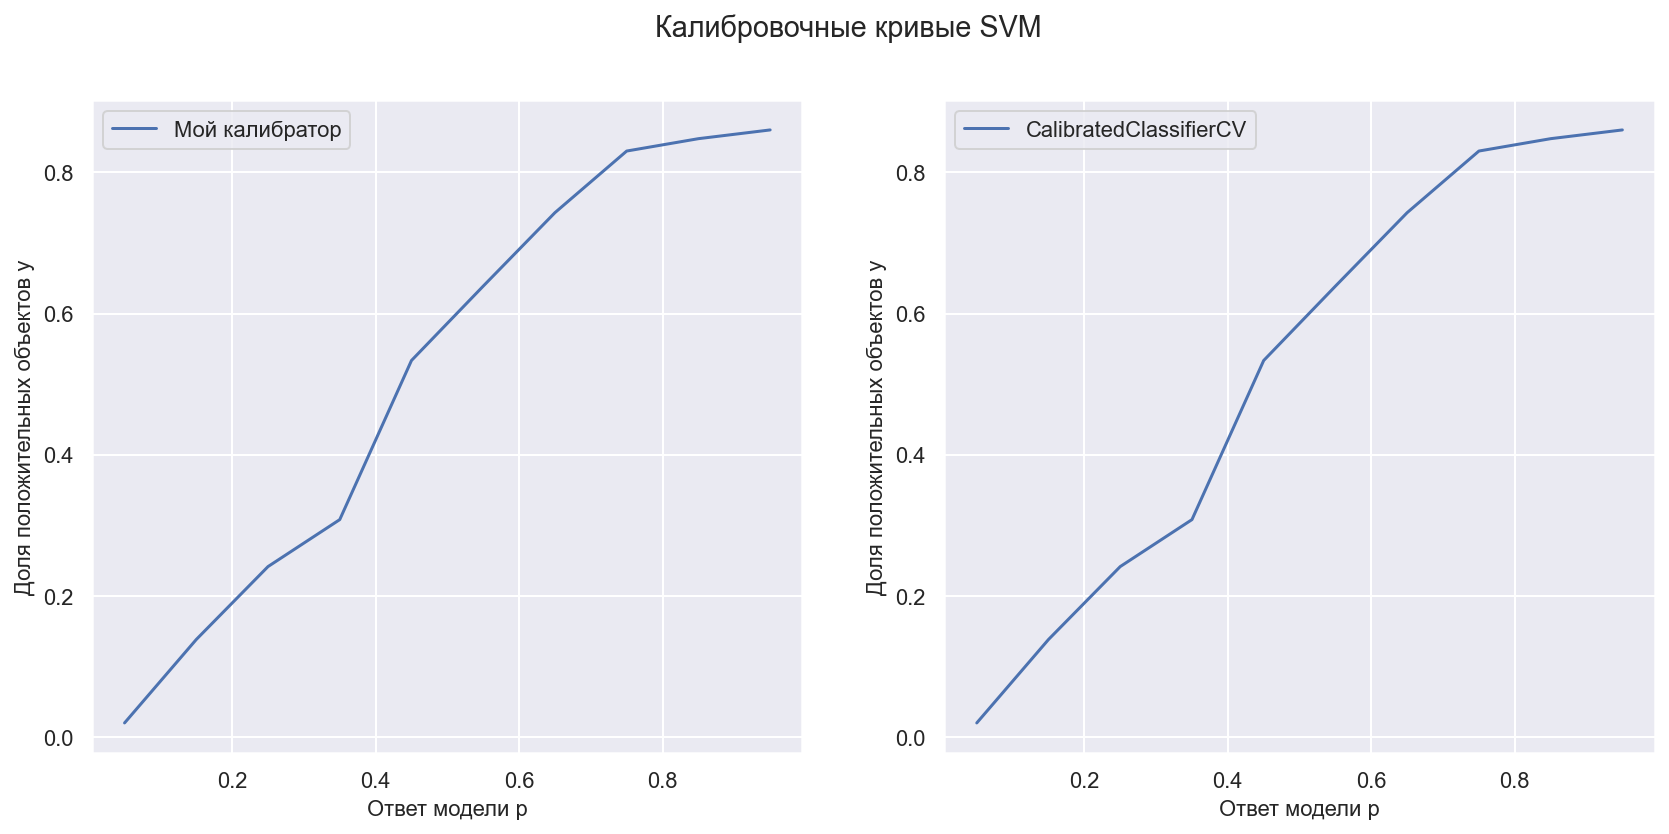

In [24]:
x1, y1 = plot_calibration_curve(y_test, clb_pred, plot=False)

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Калибровочные кривые SVM')
plt1.plot(x1, y1, label='Мой калибратор')
plt2.plot(x2, y2, label='CalibratedClassifierCV')
plt1.legend()
plt2.legend()
plt1.set_xlabel('Ответ модели p', fontsize=11)
plt1.set_ylabel('Доля положительных объектов y', fontsize=11)
plt2.set_xlabel('Ответ модели p', fontsize=11)
plt2.set_ylabel('Доля положительных объектов y', fontsize=11);

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [25]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [26]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [27]:
df = df.drop('duration', axis=1)
X, y = df.drop('y', axis=1), df['y'].map({'no': 0, 'yes': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [28]:
numeric = X_train._get_numeric_data().columns
categorical = X_train.dtypes[X_train.dtypes == "object"].index

<div class='alert alert-block alert-info'>
Очевидно, <b>duration</b>. Признак на самом деле несет в себе слишком много информации (длительность разговора говорит о результате во-первых, во-вторых до совершения звонка мы не знаем ничего о длительности</div>

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

<div class='alert alert-block alert-info'>
<b>Ответ:</b> Нам важно, пожалуй, не только правильно классифицировать объекты, упускаем ли мы положительные объекты, насколько точно мы находим положительные объекты</div>

In [29]:
from time import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

column_transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('encoding_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
model = pipeline.fit(X_train, y_train)
end = time()

y_pred = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print('Время, потребовавшееся на обучение: ', round(end - start, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на обучение: 0.947с.
AUC-PR = 0.44222


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [30]:
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('encoding', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
model = pipeline.fit(X_train, y_train)
end = time()

y_pred = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print('Время, потребовавшееся на обучение: ', round(end - start, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на обучение: 2.732с.
AUC-PR = 0.44966


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [31]:
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.uniques = {}
        self.mean = None
    
    def fit(self, X, y):
        for col in X.columns:
            self.uniques[col] = {}
            for cat in X[col].unique():
                self.uniques[col][cat] = np.mean(y[X[col] == cat] == 1)
        self.mean = y.mean()
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.columns:
            X_copy[col] = X_copy[col].map(self.uniques[col]).fillna(self.mean)
        return X_copy

In [32]:
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('mean_target', MeanTargetEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline([
    ('encoding', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
model = pipeline.fit(X_train, y_train)
end = time()

y_pred = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print('Время, потребовавшееся на обучение: ', round(end - start, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на обучение: 1.444с.
AUC-PR = 0.44276


<div class='alert alert-block alert-info'>
Посчитать среднее занимает больше времени, чем просто посчитать количество категорий (а уж с двумя то форами). Но map колонки – быстрее создания четырех.

Не задаем несуществующий порядок, там где нет такого отношения, но допускаем переобучение. Пожалуй, все логично.</div>

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [33]:
class MeanTargetEncoder_noise(MeanTargetEncoder):
    def __init__(self, scale=0.005):
        super().__init__()
        self.scale = scale

    def transform(self, X):
        return super().transform(X) + np.random.normal(scale=self.scale, size=X.size).reshape(X.shape)

In [34]:
column_transformer = ColumnTransformer([
    ('mean_target', MeanTargetEncoder_noise(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline([
    ('encoding', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
model = pipeline.fit(X_train, y_train)
end = time()

y_pred = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print('Время, потребовавшееся на обучение: ', round(end - start, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на обучение: 1.828с.
AUC-PR = 0.44218


<div class='alert alert-block alert-info'>
Результаты тут слишком рандомные, шум то улучшает, то ухудшает скор. При попытках менять дисперсию шума, я натыкалась либо на неизбежное ухудшение как следствие потери смысла признаков, либо на ухудшение как следствие переобучения.</div>

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [35]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
for col in X.columns:
    for idx, idx_ in kf.split(X):  # делю колонку на k фолдов
        for cat in X[col].unique():
            X[col].loc[idx]

In [36]:
from sklearn.model_selection import KFold

class MeanTargetEncoder_folds(MeanTargetEncoder_noise):
    def __init__(self, scale=0.005, k=4):
        super().__init__(scale)
        self.k = k
        self.kf = KFold(n_splits=self.k)
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        X_copy = X.copy()
        for col in X.columns:                                                       # для одного признака
            for idx, idx_ in self.kf.split(X):                                      # делю колонку на k фолдов
                fold = {}                                                           # для каждого фолда
                for cat in X[col].unique():                                         # прохожу по всем категориям
                    fold[cat] = np.mean(y.iloc[idx][X[col].iloc[idx] == cat] == 1)  # считаю среднее по категории
                    
                X_copy[col].iloc[idx_] = X_copy[col].iloc[idx_].map(fold).fillna(self.mean)

        return X_copy + np.random.normal(scale=self.scale, size=X.size).reshape(X.shape)

In [37]:
column_transformer = ColumnTransformer([
    ('mean_target', MeanTargetEncoder_folds(scale=0.002), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline([
    ('encoding', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
model = pipeline.fit(X_train, y_train)
end = time()

y_pred = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print('Время, потребовавшееся на обучение: ', round(end - start, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на обучение: 2.821с.
AUC-PR = 0.44255


А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [38]:
class MeanTargetEncoder_smth(MeanTargetEncoder_noise):
    def __init__(self, C=2.375):
        super().__init__()
        self.C = C
    
    def fit(self, X, y):
        self.mean = y.mean()
        for col in X.columns:
            self.uniques[col] = {}
            for cat in X[col].unique():
                self.uniques[col][cat] = (np.sum(y[X[col] == cat] == 1) + self.C * self.mean) \
                / (np.sum(X[col]==cat) + self.C)
        return self

In [39]:
column_transformer = ColumnTransformer([
    ('mean_target', MeanTargetEncoder_smth(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline([
    ('encoding', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
model = pipeline.fit(X_train, y_train)
end = time()

y_pred = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print('Время, потребовавшееся на обучение: ', round(end - start, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на обучение: 1.165с.
AUC-PR = 0.44157


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [40]:
df['age'] = df['age'].astype(object)
X, y = df.drop('y', axis=1), df['y'].map({'no': 0, 'yes': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

categorical = X_train.dtypes[X_train.dtypes == 'object'].index
print(f'У признака \'age\'', df['age'].nunique(), 'уникальных значений.')

У признака 'age' 78 уникальных значений.


In [41]:
column_transformer = ColumnTransformer([
    ('mean_target', MeanTargetEncoder_smth(-2.05), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline([
    ('encoding', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
model = pipeline.fit(X_train, y_train)
end = time()

y_pred = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print('Время, потребовавшееся на обучение: ', round(end - start, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на обучение: 1.702с.
AUC-PR = 0.44301


Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [42]:
categorical = categorical.tolist()
categorical.remove('month')
categorical.remove('day_of_week')

In [43]:
from time import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

column_transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), ['month', 'day_of_week']),
    ('mean_target', MeanTargetEncoder_smth(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline([
    ('encoding', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
model = pipeline.fit(X_train, y_train)
end = time()

y_pred = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print('Время, потребовавшееся на обучение: ', round(end - start, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на обучение: 1.831с.
AUC-PR = 0.43239


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

<div class='alert alert-block alert-info'>
<b>Ответ:</b><ul>
    <li>Чем сложнее счетчик, тем больше времени уходит на вычисления, но это время не превосходит время работы OHE, так, чтобы OHE был лучше в этом смысле.
    <li>Шум провоцирует волатильность результатов, что плохо, усложнение счетчиков может дать как улучшение, так и ухудшение. На мой взгляд, счетчики стоит использовать после OHE, если важно попытаться получить улучшение, как базовая модель OHE лучше.
    <li>Счетчики – отличный способ работы с признаками, зависимость от которых нелинейная, а значений слишком много, чтобы использовать OHE.</ul></div>

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [44]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

categorical = X_train.dtypes[X_train.dtypes == 'object'].index
numeric = X_train._get_numeric_data().columns

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [45]:
encoder = OneHotEncoder().fit(X_train[categorical])

encoded = pd.DataFrame(
    encoder.transform(X_train[categorical]).todense(),
    columns=encoder.get_feature_names(categorical), index=X_train.index
)
X_train = pd.concat((X_train.drop(categorical, axis=1), encoded), axis=1)

In [46]:
encoded = pd.DataFrame(
    encoder.transform(X_test[categorical]).todense(),
    columns=encoder.get_feature_names(categorical), index=X_test.index
)
X_test = pd.concat((X_test.drop(categorical, axis=1), encoded), axis=1)

In [47]:
print(f'После One-Hot кодирования в датасете {X_train.shape[1]} признака.')

После One-Hot кодирования в датасете 62 признака.


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [48]:
result = {}

In [49]:
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

result['Без отбора признаков'] = [auc_pr, 0]
print('AUC-PR =', round(auc_pr, 5))

AUC-PR = 0.44242


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отбора признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [50]:
# обучаем модель
start = time()
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

# отбираем 40 признаков
cols = [col[0] for col in sorted(zip(X_train.columns, np.abs(model.coef_[0])), reverse=True)[:40]]
X_train_, X_test_ = X_train[cols], X_test[cols]
res = time() - start

In [51]:
model = LogisticRegression().fit(X_train_, y_train)

y_pred = model.predict_proba(X_test_)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

result['Отбор по коэффициентам'] = [auc_pr, res]
print('Время, потребовавшееся на отбор признаков: ', round(res, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5), '< 0.44242')

Время, потребовавшееся на отбор признаков: 1.654с.
AUC-PR = 0.42687 < 0.44242


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [52]:
column_transformer = ColumnTransformer([('scaling', StandardScaler(), numeric)], remainder='passthrough')
pipeline = Pipeline([
    ('scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
pipeline.fit(X_train, y_train)

cols = [col[0] for col in sorted(zip(X_train.columns, np.abs(pipeline['regression'].coef_[0])),
                                 reverse=True)[:40]]
X_train_, X_test_ = X_train[cols], X_test[cols]
res = time() - start

In [53]:
numeric_ = [col for col in cols if col in numeric]

In [54]:
column_transformer = ColumnTransformer([('scaling', StandardScaler(), numeric_)], remainder='passthrough')
pipeline = Pipeline([
    ('scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train_, y_train)

y_pred = model.predict_proba(X_test_)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

result['Отбор по коэффициентам, scaling numeric'] = [auc_pr, res]
print('Время, потребовавшееся на отбор признаков: ', round(res, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на отбор признаков: 2.04с.
AUC-PR = 0.43955


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [55]:
column_transformer = ColumnTransformer([('scaling', StandardScaler(), X_train._get_numeric_data().columns)])
pipeline = Pipeline([
    ('scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
pipeline.fit(X_train, y_train)

cols_ = cols
cols = [col[0] for col in sorted(zip(X_train.columns, np.abs(pipeline['regression'].coef_[0])),
                                              reverse=True)[:40]]
X_train_, X_test_ = X_train[cols], X_test[cols]
res = time() - start

In [56]:
column_transformer = ColumnTransformer([('scaling', StandardScaler(), X_train_.columns)], remainder='passthrough')
pipeline = Pipeline([
    ('scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train_, y_train)

y_pred = model.predict_proba(X_test_)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

result['Отбор по коэффициентам, scaling all features'] = [auc_pr, res]
print('Время, потребовавшееся на отбор признаков: ', round(res, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5), '> 0.43955')

Время, потребовавшееся на отбор признаков: 0.62с.
AUC-PR = 0.43963 > 0.43955


In [57]:
print('Список признаков изменился:', ['верно', 'неверно'][cols_ == cols])

Список признаков изменился: неверно


### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 10 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [58]:
start = time()
t_stats = []
n = y_train.sum()
for col in X_train.columns:
    mu = X_train[y_train == 1][col].mean(), X_train[y_train == 0][col].mean()
    sigma = X_train[y_train == 1][col].var(), X_train[y_train == 0][col].var()
    t_stats += [(np.abs(mu[0] - mu[1]) \
                 / np.sqrt((n * sigma[0] + (y_train.size - n) * sigma[1]) / y_train.size), col)]
cols = [col[1] for col in sorted(t_stats, reverse=True)[:40]]
X_train_, X_test_ = X_train[cols], X_test[cols]
res = time() - start

In [59]:
column_transformer = ColumnTransformer([('scaling', StandardScaler(), X_train_.columns)], remainder='passthrough')
pipeline = Pipeline([
    ('scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train_, y_train)

y_pred = model.predict_proba(X_test_)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

result['t-статистика'] = [auc_pr, res]
print('Время, потребовавшееся на отбор признаков: ', round(res, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на отбор признаков: 1.668с.
AUC-PR = 0.45167


<div class='alert alert-block alert-info'>
Потому что статистика есть любовь</div>

### Методы-обёртки

__Задание 11 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.5, random_state=777, stratify=y_train
)

X_train_ = X_train.copy()  # из этого датасета буду выбрасывать признаки

In [61]:
def helper(X_train, X_valid, y_train, y_valid):
    prev_auc, printed = 0, False
    for i in range(X_train.shape[1] - 40):
        best = (None, 0)
        for col in X_train.columns:
            X_train, values = X_train.drop(col, axis=1), X_train[col]
            
            model = LogisticRegression(max_iter=2000).fit(X_train, y_train)
            y_pred = model.predict_proba(X_valid[X_train.columns])[:, 1]
            auc_pr = average_precision_score(y_valid, y_pred)
            
            best = best if best[1] > auc_pr else (col, auc_pr)
            X_train[col] = values
        
        if prev_auc > best[1] and not printed:
            print('Ухудшение началось после того, как выбросили признаков:', i + 1)
            print('AUC-PR =', round(prev_auc, 5))
            printed = True
        X_train = X_train.drop(best[0], axis=1)
        prev_auc = best[1]
    return X_train.columns

In [62]:
start = time()
cols = helper(X_train_, X_valid, y_train, y_valid)
res = time() - start

Ухудшение началось после того, как выбросили признаков: 6
AUC-PR = 0.44872


In [63]:
column_transformer = ColumnTransformer([('scaling', StandardScaler(), cols)], remainder='passthrough')
pipeline = Pipeline([
    ('scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train[cols], y_train)

y_pred = model.predict_proba(X_test[cols])[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

result['Удаление худших признаков'] = [auc_pr, res]
print('Время, потребовавшееся на отбор признаков: ', round(res, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на отбор признаков: 606.369с.
AUC-PR = 0.44554


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [64]:
def helper(X_train, X_valid, y_train, y_valid):
    X_result = pd.DataFrame(index=X_train.index)
    prev_auc, printed = 0, False
    for i in range(40):
        best = (None, 0)
        for col in X_train.columns:
            X_result = pd.concat((X_result, X_train[col]), axis=1)
            model = LogisticRegression(max_iter=2000).fit(X_result, y_train)
            y_pred = model.predict_proba(X_valid[X_result.columns])[:, 1]
            auc_pr = average_precision_score(y_valid, y_pred)
            
            best = best if best[1] > auc_pr else (col, auc_pr)
            X_result = X_result.drop(col, axis=1)
        if prev_auc > best[1] and not printed:
            print(f'Добавление {i + 1}-го признака ухудшило результаты модели.')
            print('AUC-PR =', round(prev_auc, 5))
            printed = True
        X_result = pd.concat((X_result, X_train[best[0]]), axis=1)
        X_train = X_train.drop(best[0], axis=1)
        prev_auc = best[1]
    return X_result.columns

In [65]:
start = time()
cols = helper(X_train_, X_valid, y_train, y_valid)
res = time() - start

Добавление 14-го признака ухудшило результаты модели.
AUC-PR = 0.44049


In [66]:
column_transformer = ColumnTransformer([('scaling', StandardScaler(), cols)], remainder='passthrough')
pipeline = Pipeline([
    ('scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train[cols], y_train)

y_pred = model.predict_proba(X_test[cols])[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

result['Добавление лучших признаков'] = [auc_pr, res]
print('Время, потребовавшееся на отбор признаков: ', round(res, 3), 'с.', sep='')
print('AUC-PR =', round(auc_pr, 5))

Время, потребовавшееся на отбор признаков: 186.982с.
AUC-PR = 0.44569


In [67]:
pd.DataFrame(result, index=['AUC-PR', 'Время'])

,Без отбора признаков,Отбор по коэффициентам,"Отбор по коэффициентам, scaling numeric","Отбор по коэффициентам, scaling all features",t-статистика,Удаление худших признаков,Добавление лучших признаков
AUC-PR,0.442422,0.426873,0.439549,0.439630,0.451669,0.445539,0.445690
Время,0.000000,1.654499,2.039910,0.620058,1.668133,606.369152,186.982066


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

<div class='alert alert-block alert-info'>
    Во всей таблице AUC-PR вычислена для моделей на 40 признаках.<br>
<ol><li>Отбор по коэффициентам не слишком эффективен, даже при скейлинге всех признаков
    <li>Сравнение средних значений для категорий таргета дает лучшие результаты за малое время
    <li>Удаление худших признаков занимает слишком много времени, но может дать хорошие результаты (в случае, если останавливаться при первом ухудшении, хоть мы не знаем ничего про дальнейшие изменения, можно получить AUC-PR = 0.44872)
    <li>Добавление лучших признаков, очевидно, быстрее, чем удаление. От этого эффективность не страдает.</ol></div>

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 12 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [68]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X, y = df.drop(columns=['duration', 'y']), (df.y == 'yes')

In [69]:
categorical = X.dtypes[X.dtypes == 'object'].index
numeric = X._get_numeric_data().columns

In [70]:
from collections import defaultdict

result = defaultdict(list)
kf = KFold(shuffle=True, random_state=500)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])
model = Pipeline([
    ('encode_and_scale', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

for i, (idx, idx_) in enumerate(kf.split(X)):
    model.fit(X.iloc[idx], y[idx])
    
    y_pred = model.predict(X.iloc[idx_])
    result['costs'].append(y_pred.sum())
    result['revenue'].append(y[idx_][y_pred].sum() * 10)
    result['profit'].append(result['revenue'][-1] - result['costs'][-1])

In [71]:
# косты – затраты на з/п, revenue – доход с правильно классифицированных положительных объектов
result = pd.DataFrame(result, index=[f'fold {i}' for i in range(1, 6)]).T
result['mean'] = result.mean(axis=1)
result

,fold 1,fold 2,fold 3,fold 4,fold 5,mean
costs,310,330,330,330,321,324.2
revenue,2240,2110,2090,2250,1960,2130.0
profit,1930,1780,1760,1920,1639,1805.8


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [80]:
from collections import defaultdict

result = defaultdict(list)
kf = KFold(shuffle=True, random_state=500)

for i, (idx, idx_) in enumerate(kf.split(X)):
    model.fit(X.iloc[idx], y[idx])
    
    y_pred = model.predict(X.iloc[idx_])
    result['costs'].append(y_pred.sum())
    result['revenue'].append((y[idx_][y_pred] * np.random.uniform(0, 20, y[idx_][y_pred].size)).sum())
    result['profit'].append(result['revenue'][-1] - result['costs'][-1])

In [81]:
result = pd.DataFrame(result, index=[f'fold {i}' for i in range(1, 6)]).T
result['mean'] = result.mean(axis=1)
result

,fold 1,fold 2,fold 3,fold 4,fold 5,mean
costs,310.000000,330.00000,330.000000,330.000000,321.000000,324.200000
revenue,2328.209727,2196.67219,2179.989724,2312.733009,1720.473707,2147.615671
profit,2018.209727,1866.67219,1849.989724,1982.733009,1399.473707,1823.415671


In [82]:
print('Количество объектов n =', X.shape[0])

Количество объектов n = 41188


<div class='alert alert-block alert-info'>
    Средняя прибыль примерно та же. Объектов достаточно, чтобы мы получили среднее.</div>

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [85]:
# тут я делаю свой скоринг – прибыль, по дефолту чем больше, тем лучше
from sklearn.metrics import make_scorer

def profit(y, y_pred):
    return (y[y_pred] * np.random.uniform(0, 20, y[y_pred].size)).sum() - y_pred.sum()

scorer = make_scorer(profit)

In [86]:
searcher = GridSearchCV(model, {'regression__C': np.logspace(-3, 2, 30)}, scoring=scorer, n_jobs=-1, verbose=True)
searcher.fit(X, y);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


Лучший параметр C = 0.002212


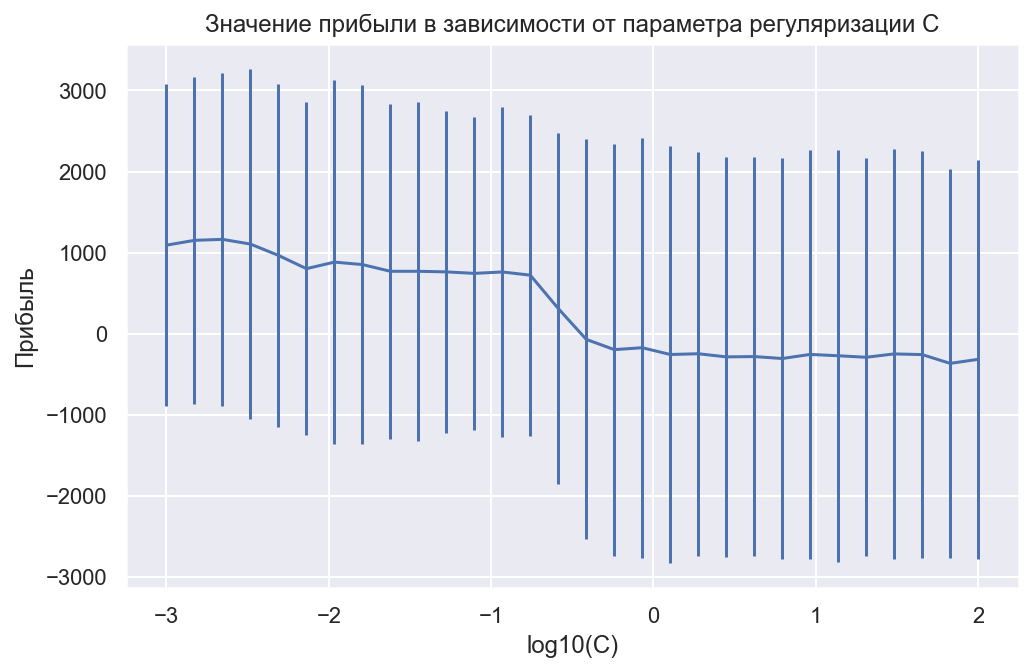

In [87]:
c = searcher.best_params_['regression__C']
print('Лучший параметр C =', round(c, 6))
plt.errorbar(np.linspace(-3, 2, 30),
             searcher.cv_results_['mean_test_score'],
             searcher.cv_results_['std_test_score']);
plt.title('Значение прибыли в зависимости от параметра регуляризации C')
plt.xlabel('log10(C)')
plt.ylabel('Прибыль');

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

1-ый фолд, лучший параметр C = 0.001487
2-ый фолд, лучший параметр C = 0.002212
3-ый фолд, лучший параметр C = 0.00329
4-ый фолд, лучший параметр C = 0.002212


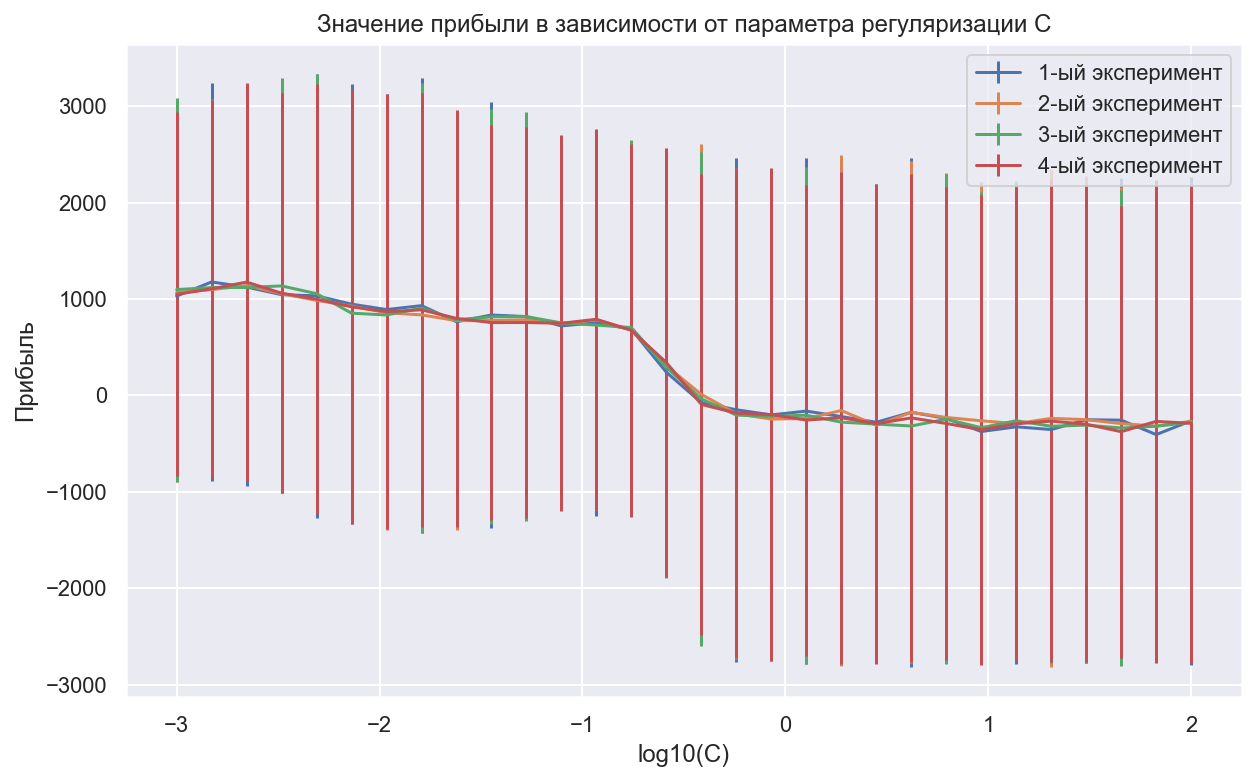

In [89]:
plt.figure(figsize=(10, 6))
for i in range(4):
    searcher = GridSearchCV(model, {'regression__C': np.logspace(-3, 2, 30)}, scoring=scorer, n_jobs=-1)
    searcher.fit(X, y)
    
    print(f'{i + 1}-ый фолд, лучший параметр C =', round(searcher.best_params_['regression__C'], 6))
    plt.errorbar(
        np.linspace(-3, 2, 30),
        searcher.cv_results_['mean_test_score'],
        searcher.cv_results_['std_test_score'],
        label=f'{i + 1}-ый эксперимент'
                );

plt.legend()
plt.title('Значение прибыли в зависимости от параметра регуляризации C')
plt.xlabel('log10(C)')
plt.ylabel('Прибыль');

__Задание 13 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

In [90]:
print('Предположим, что мы прозваниваем абсолютно всех клиентов, не используя предсказаний модели.')
print('Наши расходы в таком случае c =', y.sum() / 5)  # делю на количество фолдов
print('Выручка r =', (y * np.random.uniform(0, 20, y.size)).sum() / 5)
print('Прибыль p =', ((y * np.random.uniform(0, 20, y.size)).sum() - y.sum()) / 5)

Предположим, что мы прозваниваем абсолютно всех клиентов, не используя предсказаний модели.
Наши расходы в таком случае c = 928.0
Выручка r = 9381.007213521409
Прибыль p = 8447.338873658446


<div class='alert alert-block alert-info'>
Если гипотетически мы абсолютно всех клиентов отметим как положительных, то есть FP возрастет, а FN = 0, $\text{recall} = {\text{TP}\over{\text{TP} + \text{FN}}} = 1.$ Одновременно с этим знаменатель $\text{precision}$ возрастет. А прибыль будет выше средней. Исходя из чего делаю вывод, что recall важнее</div>

Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [92]:
result = defaultdict(list)
kf = KFold(shuffle=True, random_state=500)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])
model = Pipeline([
    ('encode_and_scale', column_transformer),
    ('regression', LogisticRegression(C=c, max_iter=1000))
])

for p in np.linspace(0, 1, 100):
    for i, (idx, idx_) in enumerate(kf.split(X)):
        model.fit(X.iloc[idx], y[idx])
    
        y_pred = model.predict_proba(X.iloc[idx_])[:, 1] > p
        result['costs'].append(y_pred.sum())
        result['revenue'].append((y[idx_][y_pred] * np.random.uniform(0, 20, y[idx_][y_pred].size)).sum())
        result['profit'].append(result['revenue'][-1] - result['costs'][-1])

In [97]:
result_ = np.array(pd.DataFrame(result)).reshape(100, -1, 3)
mean = result_.mean(axis=1)
std = result_.std(axis=1)

In [104]:
result_ = pd.DataFrame(
    np.hstack((np.linspace(0, 1, 100).reshape(-1, 1), mean, std)),
    columns=['Порог t', 'mean costs', 'mean revenue', 'mean profit', 'costs std', 'revenue std', 'profit std']
)
result_.head(5)

,Порог t,mean costs,mean revenue,mean profit,costs std,revenue std,profit std
0,0.000000,8237.6,9200.110525,962.510525,0.489898,211.985592,211.923576
1,0.010101,8237.2,9185.569910,948.369910,0.748331,267.005581,266.928655
2,0.020202,8223.0,9341.888977,1118.888977,5.899152,316.898994,320.458687
3,0.030303,8071.8,9335.167348,1263.367348,20.730654,400.550250,410.857694
4,0.040404,6954.0,8848.628406,1894.628406,80.386566,286.751727,337.033880


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.

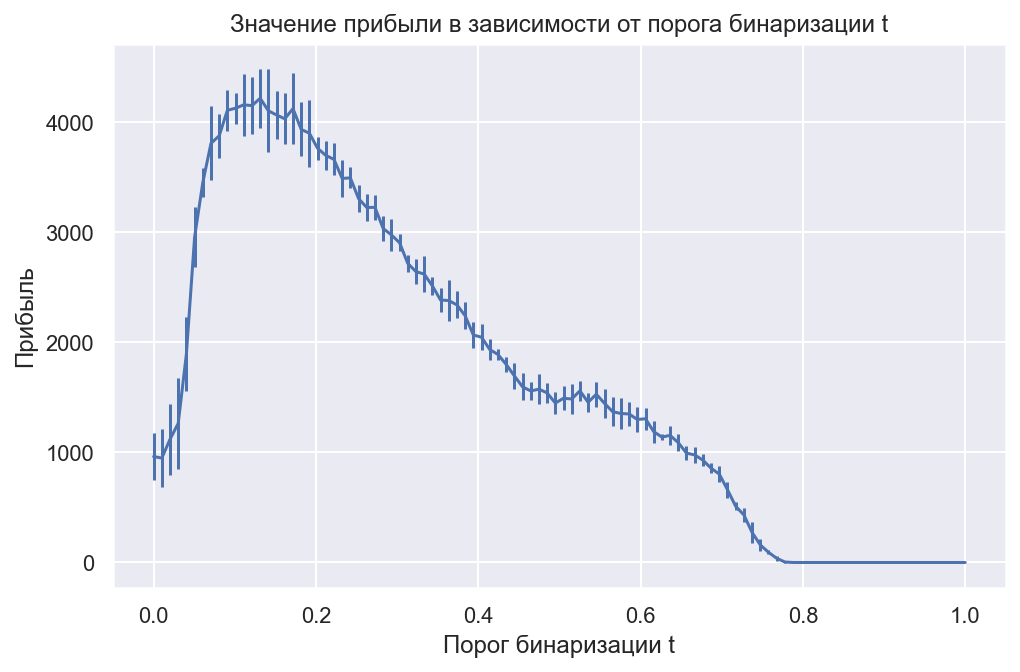

In [105]:
plt.errorbar(np.linspace(0, 1, 100),
             result_['mean profit'],
             result_['profit std']);
plt.title('Значение прибыли в зависимости от порога бинаризации t')
plt.xlabel('Порог бинаризации t')
plt.ylabel('Прибыль');

In [110]:
result_[result_['mean profit'] == result_['mean profit'].max()]['Порог t'].values[0]

0.13131313131313133

<div class='alert alert-block alert-info'>
$t \in [0.1, 0.2]$ – наилучшая область.<br>
$t = 0.13131$ – наилучший порог</div>

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [131]:
result = defaultdict(list)
for i in range(4):
    for p in np.linspace(0, 1, 100):
        for i, (idx, idx_) in enumerate(kf.split(X)):
            model.fit(X.iloc[idx], y[idx])

            y_pred = model.predict_proba(X.iloc[idx_])[:, 1] > p
            result['costs'].append(y_pred.sum())
            result['revenue'].append((y[idx_][y_pred] * np.random.uniform(0, 20, y[idx_][y_pred].size)).sum())
            result['profit'].append(result['revenue'][-1] - result['costs'][-1])
    result_ = np.array(pd.DataFrame(result)).reshape(100, -1, 3)
    mean = result_.mean(axis=1)
    t = np.linspace(0, 1, 100)[mean[:, 2] == mean[:, 2].max()][0]
    print('Лучший порог t =', t)

Лучший порог t = [0.13131313]
Лучший порог t = [0.06060606]
Лучший порог t = [0.04040404]
Лучший порог t = [0.03030303]


<div class='alert alert-block alert-info'>
Чем меньше порог, тем лучше, но до определенного момента ($t <= 0.15$), дальше растет стандартное отклонение, результаты колеблются, с дальнейшим уменьшением порога падает и прибыль. То есть прозванивать всех клиентов без исключения тоже не выгодно. Можно отсеивать тех, что откажется с 85-95%-ной вероятностью  </div>

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [140]:
t = 0.07
precision, recall = [], []
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])
model = Pipeline([
    ('encode_and_scale', column_transformer),
    ('regression', LogisticRegression(C=c, max_iter=1000))
])

for i, (idx, idx_) in enumerate(kf.split(X)):
    model.fit(X.iloc[idx], y[idx])
    
    y_pred = model.predict_proba(X.iloc[idx_])[:, 1] > t
    precision.append(y_pred[y[idx_]].sum() / y_pred.sum())
    recall.append(y_pred[y[idx_]].sum() / (y_pred[y[idx_]].sum() + y_pred[y[idx_]].size - y_pred[y[idx_]].sum()))

In [141]:
recall = np.array(recall)
std_recall = recall.std()

precision = np.array(precision)
std_precision = precision.std()

print('Mean recall =', round(recall.mean(), 5), '\nstd =', round(std_recall, 5))
print('\nMean precision =', round(precision.mean(), 5), '\nstd =', round(std_precision, 5))

Mean recall = 0.74165 
std = 0.00553

Mean precision = 0.22233 
std = 0.00858


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

<div class='alert alert-block alert-info'>
Вот тут я уже торопилась. Значение какое-то неправдоподобное</div>

In [161]:
y_pred_ = model.predict_proba(X.iloc[idx_])[:, 1]

precision, recall = [], []
for p in np.linspace(0, 1, 100):
    y_pred = y_pred_ > p
    tp = y_pred[y[idx_]].sum()
    tp_fp = y_pred.sum()
    fn = y_pred[y[idx_]].size - y_pred[y[idx_]].sum()
    precision.append(tp / tp_fp)
    recall.append(tp / (tp + fn))

precision = np.array(precision)
recall = np.array(recall)

precision_ = precision[recall >= 0.5]
recall_ = recall[recall >= 0.5]

pr_auc = auc(recall_, precision_)
print('PR-AUC =', round(pr_auc, 5))

PR-AUC = 0.11994


<ipython-input-161-ffcbf927f155>:9: RuntimeWarning: invalid value encountered in long_scalars
  precision.append(tp / tp_fp)


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ горстку дедлайнов. Бодрящий вкус, всем рекомендую с: